In [1]:
import sys
sys.path.append("../src")

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import umap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

from lib.i_o import read_csv

## Preprocessing

In [2]:
df_x_train = read_csv("X_train.csv", "../data/").drop(columns="id")
df_y_train = read_csv("y_train.csv", "../data/").drop(columns="id")

Read data from ../data/X_train.csv
Read data from ../data/y_train.csv


In [3]:
df_x_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,14168.823171,10514.380717,3316.149698,94230.695124,102.386606,92.677127,11108.748199,10866.505510,10837.622093,10.227734,...,NaN,12352.094085,846.014651,105.132144,102.112809,2090.004260,2.691845,1234.374109,1000.784475,9285.751272
1,17757.037554,NaN,4101.016273,92959.527633,NaN,99.855168,10013.959449,10826.607494,10076.101597,11.436970,...,NaN,16198.071494,776.084467,106.385590,103.472030,2474.051881,2.287976,NaN,1012.626705,11750.284764
2,14226.656663,11029.642499,NaN,124055.600561,100.542483,92.860892,NaN,10492.342868,NaN,10.810076,...,10329.704431,13976.063780,737.040332,103.671234,109.458246,2656.083281,2.843706,888.353607,1048.810385,9553.922728
3,8766.012436,7384.202998,2147.308418,100157.719990,104.855061,101.929026,10050.049932,10499.521099,10525.030989,10.092109,...,10008.251395,6212.127347,329.044233,105.084488,104.858546,1097.785204,2.732257,927.752967,1048.357330,NaN
4,13801.016418,13269.493652,3408.316953,92048.527786,103.759758,95.789235,9667.353978,10750.783106,10618.800750,12.006773,...,10095.782015,13772.061493,NaN,NaN,100.369834,2693.053231,2.702908,1471.354073,1071.284484,9423.533063


In [4]:
# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_x_train, df_y_train, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=1) 

In [5]:
print(f"#Features: {df_x_train.shape[1]}\n#observations: {df_x_train.shape[0]}")

#Features: 832
#observations: 1212


In [6]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
feature_scaler = preprocessing.RobustScaler().fit(X_train)
X_train_scaled = pd.DataFrame(feature_scaler.transform(X_train))

feature_imputer = KNNImputer(missing_values=np.nan, weights="distance").fit(X_train_scaled)
X_train_imputed = pd.DataFrame(feature_imputer.transform(X_train_scaled))

y_scaler = preprocessing.RobustScaler().fit(y_train)
y_train_scaled = pd.DataFrame(y_scaler.transform(y_train))
y_scaled_imputer = KNNImputer(missing_values=np.nan, weights="distance").fit(y_train_scaled)
y_imputer = KNNImputer(missing_values=np.nan, weights="distance").fit(y_train)
y_train_scaled_imputed = pd.DataFrame(y_scaled_imputer.transform(y_train_scaled))
y_train_imputed = pd.DataFrame(y_imputer.transform(y_train))

In [7]:
X_train_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,822,823,824,825,826,827,828,829,830,831
0,0.753935,-0.508197,-0.241217,0.332667,-0.295885,-0.619500,0.824783,-0.235241,-0.618928,0.667615,...,-0.045697,0.267282,0.672470,-0.402731,-1.025642,0.715393,-0.341415,-0.041119,-0.817961,-0.663576
1,-0.311504,-0.967523,-0.695675,0.525044,0.523429,-1.495459,-1.159030,0.200787,0.330194,-0.815643,...,-0.088430,-0.650138,-0.382387,-0.804350,-0.688725,0.177733,0.643052,0.131973,-0.950224,0.715374
2,0.181911,0.071630,-0.761332,0.734662,0.255576,-1.591970,-0.226300,0.498284,-0.299950,-1.559003,...,-1.365657,-0.047609,-0.945193,-0.318193,0.374489,0.724512,0.411854,-0.452478,-0.059310,0.361108
3,0.519243,0.058788,1.981992,0.856846,0.220920,1.929729,-0.670960,-0.251344,-0.138205,1.564303,...,0.215346,0.929478,0.610787,0.855131,0.441871,0.598463,-0.053654,1.266091,0.361550,0.394538
4,0.326490,0.735942,0.557099,0.303802,0.647149,-0.476441,-0.622404,-0.074809,0.685236,0.045622,...,-0.472905,0.726765,-1.340824,-0.000072,0.291784,0.718355,0.006252,0.512985,-0.333899,-0.287697


In [8]:
# Remove outliers
num_observation_before = X_train_imputed.shape[0]

# X_train_inliers = X_train_imputed[X_train_imputed['is_inlier']].drop(columns=['is_inlier'])
# y_train_inliers = y_train_imputed[X_train_imputed['is_inlier']]

# No outlier removal
X_train_inliers = X_train_imputed
y_train_inliers = y_train_imputed

num_observation_after = X_train_inliers.shape[0]
print(f"#Outliers removed: {num_observation_before - num_observation_after}")

#Outliers removed: 0


In [9]:
# Prepare validation set
X_val_scaled = feature_scaler.transform(X_val)
X_val_imputed = feature_imputer.transform(X_val_scaled)
y_val_imputed = y_imputer.transform(y_val)

X_val_scaled.shape

(155, 832)

In [10]:
pd.DataFrame(X_val_imputed).head()

,0,1,2,3,4,5,6,7,8,9,...,822,823,824,825,826,827,828,829,830,831
0,0.598315,-0.369891,-0.301459,1.499899,0.744178,0.590331,0.157772,-0.618750,-0.189304,0.089605,...,0.273699,0.207212,0.553760,-0.450498,0.044669,0.395343,-0.311170,-0.417979,-0.125990,0.246327
1,1.028287,0.354863,0.237556,-0.099442,0.510996,0.716111,-0.018175,0.719014,0.846400,0.331800,...,-0.704880,0.479464,-0.431005,-0.193266,0.530963,1.563002,-0.287511,-0.367720,0.862000,-0.002443
2,1.393176,0.781744,0.242804,-0.293579,-0.576562,-0.266954,-0.985080,0.473554,-0.849690,-0.117892,...,0.742842,0.361695,0.620908,0.636031,-0.094609,0.572193,-0.261774,-0.217021,0.559840,-0.152908
3,-0.721681,0.475414,0.182536,0.626322,-0.066166,-0.285571,0.406140,-0.253475,-0.009020,1.045911,...,-0.727014,-0.138486,0.347095,0.365304,-0.841309,0.393855,0.160740,0.953889,0.913340,1.415471
4,0.357231,0.249859,0.512986,0.070424,-0.173431,-0.410201,-0.407829,0.661011,0.756683,-0.142376,...,1.141696,-0.417805,-0.444143,0.502788,-1.015679,-0.623139,-0.874393,0.674095,0.230185,0.033976


## Model training

In [12]:
# Train variable selector
from sklearn.feature_selection import SelectFromModel

selector_model = selector_model = GradientBoostingRegressor(
    random_state=0,
    n_estimators=70,
    subsample=0.7,
    max_features=0.9,
    learning_rate=0.06
)
# selector_model = model
var_selector = SelectFromModel(estimator=selector_model, threshold="2*mean").fit(X_train_inliers, np.array(y_train_inliers).ravel())
print(f"Threshold for selecting features: {round(var_selector.threshold_, 7)}")

Threshold for selecting features: 0.0024038


In [13]:
# Remove features
dim_before = X_train_inliers.shape[1]
X_train_selected = var_selector.transform(X_train_inliers)
X_val_selected = var_selector.transform(X_val_imputed)

print(f"#Removed feature: {dim_before - X_train_selected.shape[1]}")

#Removed feature: 771


## Input cell below 

In [14]:
# WITHOUT variable selection
# _train = X_train_inliers
# _val = X_val_imputed

# WITH variable selection
_train = X_train_selected
_val = X_val_selected

In [15]:
# Train regression model
reg_model = GradientBoostingRegressor(random_state=0, n_estimators=35, subsample=0.91, max_features=0.9, learning_rate=0.19)

reg_model.fit(_train, np.array(y_train_inliers).ravel())
print(f"#features used for training: {_train.shape[1]}")

#features used for training: 61


In [16]:
# Make predictions
train_pred = reg_model.predict(_train)
val_pred = reg_model.predict(_val)

print(f"#features used for prediction: {_train.shape[1]}")

#features used for prediction: 61


## Analysis of model performance

In [17]:
# Compute residuals
# for training data
y_train_inliers_reset_index = pd.Series(y_train_inliers.reset_index()[0]) 
residuals_train = y_train_inliers_reset_index - pd.Series(train_pred)
squared_residuals_train = residuals_train**2

# for val data
y_val_reset_index = pd.Series(y_val_imputed.ravel()) 
residuals_val = y_val_reset_index - pd.Series(val_pred)
squared_residuals_val = residuals_val**2

In [18]:
df_residuals_train = pd.DataFrame({
    'residuals': residuals_train.apply(lambda x: abs(x))
    , 'y': y_train_inliers_reset_index
    , 'pred': train_pred
})

df_residuals_val = pd.DataFrame({
    'residuals': residuals_val.apply(lambda x: abs(x))
    , 'y': y_val_reset_index
    , 'pred': val_pred
})

In [35]:
df_analysis_residuals_train = df_residuals_train.groupby('y').apply(lambda x: pd.Series({
    'cnt': x['residuals'].shape[0]
    , 'mean_residuals': x['residuals'].mean()
    , 'std_residuals': x['residuals'].std()
    , 'mean_pred': x['pred'].mean()
    , 'std_pred': x['pred'].std()
})).sort_values(by='mean_residuals', ascending=False).reset_index()

In [109]:
df_analysis_residuals_train

,y,cnt,mean_residuals,std_residuals,mean_pred,std_pred
0,95.0,1.0,15.556177,NaN,79.443823,NaN
1,93.0,1.0,10.474595,NaN,82.525405,NaN
2,97.0,1.0,9.119346,NaN,87.880654,NaN
3,94.0,1.0,8.994821,NaN,85.005179,NaN
4,92.0,2.0,8.740250,0.251498,83.259750,0.251498
5,43.0,1.0,8.678624,NaN,51.678624,NaN
6,50.0,5.0,8.197334,0.885912,58.197334,0.885912
7,48.0,5.0,7.871690,2.602643,55.871690,2.602643
8,47.0,1.0,7.853733,NaN,54.853733,NaN
9,96.0,1.0,7.603731,NaN,88.396269,NaN


In [117]:
df_analysis_residuals[['y', 'cnt_train', 'prob']]

,y,cnt_train,prob
0,89.0,3.0,0.003726
1,50.0,5.0,0.006415
2,94.0,1.0,0.001160
3,95.0,1.0,0.001159
4,53.0,12.0,0.013293
5,52.0,9.0,0.010680
6,87.0,9.0,0.010309
7,49.0,7.0,0.007620
8,48.0,5.0,0.005549
9,82.0,14.0,0.018945


In [37]:
df_analysis_residuals_val = df_residuals_val.groupby('y').apply(lambda x: pd.Series({
    'cnt': x['residuals'].shape[0]
    , 'mean_residuals': x['residuals'].mean()
    , 'std_residuals': x['residuals'].std()
    , 'mean_pred': x['pred'].mean()
    , 'std_pred': x['pred'].std()
})).sort_values(by='mean_residuals', ascending=False).reset_index()

In [103]:
df_analysis_residuals = pd.merge(
    df_analysis_residuals_val, 
    df_analysis_residuals_train, 
    how="left", 
    right_on="y", 
    left_on="y", 
    suffixes=("_val", "_train"))

In [114]:
from sklearn.neighbors import KernelDensity
import numpy as np
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(np.array(y_train_inliers))
log_density = kde.score_samples(np.array(pd.DataFrame([45., 70., 95.])))
np.exp(log_density)

df_analysis_residuals['prob'] = np.exp(kde.score_samples(pd.DataFrame(df_analysis_residuals['y'])))
df_analysis_residuals['anomaly_score'] = df_residuals['prob']*df_analysis_residuals['mean_residuals_train']

/home/bjn/PycharmProjects/predicting_age/venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KernelDensity was fitted without feature names
  warnings.warn(


In [108]:
df_residuals_train['prob'] = np.exp(kde.score_samples(pd.DataFrame(df_residuals_train['y'])))
df_residuals_train['anomaly_score'] = df_residuals_train['prob']*df_residuals_train['residuals']
df_residuals_train.sort_values(by='anomaly_score', ascending=False).head(30)

/home/bjn/PycharmProjects/predicting_age/venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KernelDensity was fitted without feature names
  warnings.warn(


,residuals,y,pred,prob,anomaly_score
688,10.631293,67.0,77.631293,0.049570,0.526990
431,9.703057,69.0,59.296943,0.042574,0.413103
664,12.123005,79.0,66.876995,0.033718,0.408764
637,9.169896,66.0,75.169896,0.040152,0.368192
682,9.119931,66.0,75.119931,0.040152,0.366185
562,8.409825,69.0,77.409825,0.042574,0.358044
561,7.221329,67.0,74.221329,0.049570,0.357959
788,7.996941,73.0,65.003059,0.042276,0.338079
118,8.318651,66.0,74.318651,0.040152,0.334012
418,7.768640,72.0,64.231360,0.042102,0.327074


<Axes: ylabel='anomaly_score'>

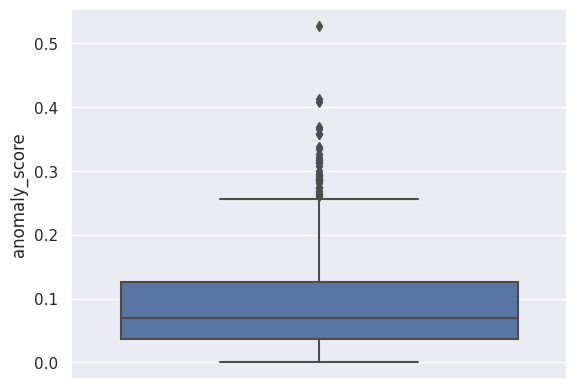

In [102]:
sns.boxplot(data=df_residuals_train, y='anomaly_score')

In [107]:
np.quantile(df_residuals_train['anomaly_score'], [0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

array([0.03588718, 0.06951649, 0.12526805, 0.14562098, 0.19112334,
       0.23952437])

count    61.000000
mean      0.016393
std       0.034821
min       0.000000
25%       0.004479
50%       0.008544
75%       0.015979
max       0.264868
Name: 0, dtype: float64

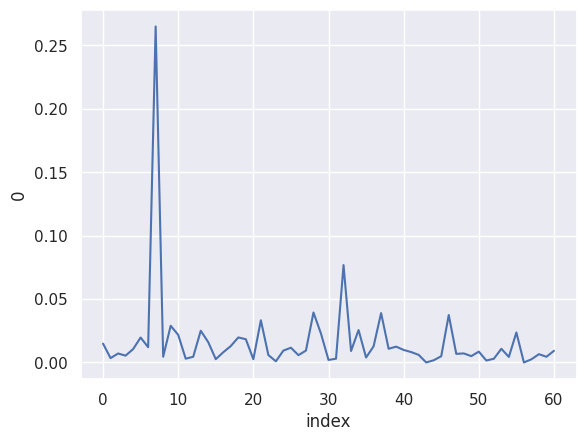

In [21]:
df_feature_importance = pd.DataFrame(reg_model.feature_importances_).reset_index()
sns.lineplot(data=df_feature_importance, x='index', y=0)
df_feature_importance[0].describe()

In [22]:
val_sorted_index = (y_val.reset_index()['y'] - pd.Series(val_pred)).apply(lambda x: abs(x)).sort_values(ascending=False).index
y_val_sorted = y_val.reset_index()['y'][val_sorted_index]

/home/bjn/PycharmProjects/predicting_age/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: ylabel='y'>

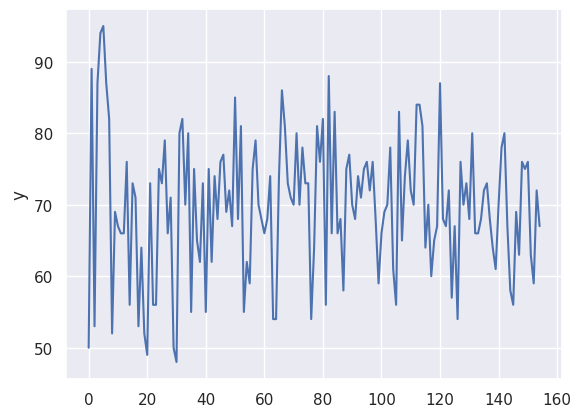

In [23]:
sns.lineplot(range(0, y_val_sorted.shape[0]), y_val_sorted)

In [24]:
normalized_residuals = pd.Series((squared_residuals_train / squared_residuals_train.sum())).sort_values(ascending=False)

/home/bjn/PycharmProjects/predicting_age/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: ylabel='0'>

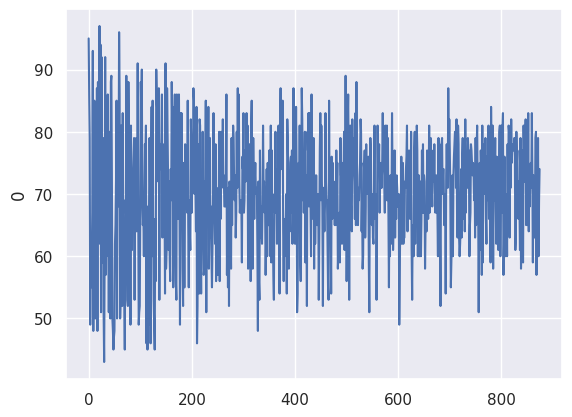

In [25]:
sns.lineplot(range(0, y_train_inliers_reset_index.shape[0]), y_train_inliers_reset_index.loc[normalized_residuals.index])

In [26]:
above = 10

theor_perc = round(above/normalized_residuals.shape[0], 2)
actual_perc = round(normalized_residuals.head(10).sum(), 2)
print(f"Contribution of top {above} theoretical / actual: {theor_perc} / {actual_perc}")

Contribution of top 10 theoretical / actual: 0.01 / 0.1


/home/bjn/PycharmProjects/predicting_age/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='mean_residuals_train'>

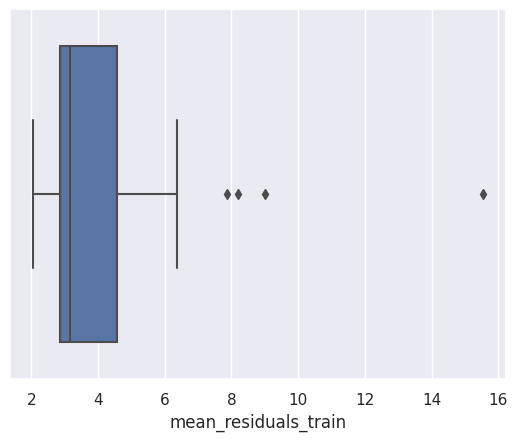

In [73]:
sns.boxplot(df_residuals['mean_residuals_train'])

In [28]:
validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train_inliers, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}")

Training score 0.818
Validation score 0.568


## Pipeline

<Axes: xlabel='Count', ylabel='0'>

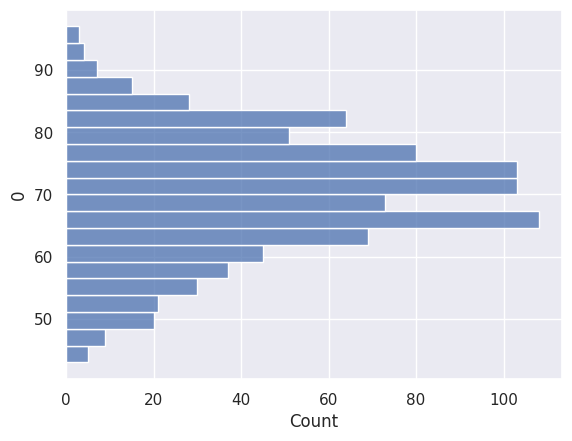

In [68]:
sns.histplot(data=pd.DataFrame(y_train_inliers), y=0)